In [103]:
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [104]:
df = pd.read_csv("train.csv")
df.isnull().sum()


StudentID              0
Age                    0
Gender                 0
Ethnicity              0
ParentalEducation    142
StudyTimeWeekly        0
Absences               0
Tutoring               0
ParentalSupport      132
Extracurricular        0
Sports                 0
Music                  0
Volunteering           0
GPA                    0
dtype: int64

### numeric fields 
- some of the fields like ParentalEducation , ParentalSupport should be in numeric form 


In [105]:
# replacing the missing value with the most frequesnt ones in the dataset

education_mode = df['ParentalEducation'].mode()[0]
support_mode = df['ParentalSupport'].mode()[0]

df['ParentalEducation'].fillna(education_mode, inplace=True)
df['ParentalSupport'].fillna(support_mode, inplace=True)

print(f"\nReplaced ParentalEducation nulls with: {education_mode}")
print(f"Replaced ParentalSupport nulls with: {support_mode}")
df.isnull().sum()


Replaced ParentalEducation nulls with: Some College
Replaced ParentalSupport nulls with: Moderate


/tmp/ipykernel_7688/1684217187.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ParentalEducation'].fillna(education_mode, inplace=True)
/tmp/ipykernel_7688/1684217187.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
dtype: int64

In [106]:
# categorial to some numeric value

df['ParentalEducation'] = pd.factorize(df['ParentalEducation'])[0]
df['ParentalSupport'] = pd.factorize(df['ParentalSupport'])[0]
df['Ethnicity'] = pd.factorize(df['Ethnicity'])[0]

In [107]:
# diffrentiat ethe values and stuff
X = df.drop(['StudentID', 'GPA'], axis=1)
y = df['GPA']

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nTraining set shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print("\nTesting set shapes:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")



Training set shapes:
X_train: (1224, 12)
y_train: (1224,)

Testing set shapes:
X_test: (306, 12)
y_test: (306,)


In [109]:
# vonersion to PyTorch tensors 
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [110]:
from torch.utils.data import DataLoader, TensorDataset
#Create data loaders

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [111]:
# the model

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [112]:
input_dim = X_train_tensor.shape[1]
model = SimpleNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
model.train()

SimpleNN(
  (layer1): Linear(in_features=12, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [113]:
costs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        costs.append(loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation

Epoch [10/1000], Loss: 0.0746
Epoch [20/1000], Loss: 0.0601
Epoch [30/1000], Loss: 0.0534
Epoch [40/1000], Loss: 0.0487
Epoch [50/1000], Loss: 0.0426
Epoch [60/1000], Loss: 0.0387
Epoch [70/1000], Loss: 0.0352
Epoch [80/1000], Loss: 0.0318
Epoch [90/1000], Loss: 0.0277
Epoch [100/1000], Loss: 0.0255
Epoch [110/1000], Loss: 0.0212
Epoch [120/1000], Loss: 0.0196
Epoch [130/1000], Loss: 0.0174
Epoch [140/1000], Loss: 0.0157
Epoch [150/1000], Loss: 0.0146
Epoch [160/1000], Loss: 0.0133
Epoch [170/1000], Loss: 0.0124
Epoch [180/1000], Loss: 0.0117
Epoch [190/1000], Loss: 0.0125
Epoch [200/1000], Loss: 0.0109
Epoch [210/1000], Loss: 0.0108
Epoch [220/1000], Loss: 0.0099
Epoch [230/1000], Loss: 0.0089
Epoch [240/1000], Loss: 0.0083
Epoch [250/1000], Loss: 0.0081
Epoch [260/1000], Loss: 0.0077
Epoch [270/1000], Loss: 0.0078
Epoch [280/1000], Loss: 0.0079
Epoch [290/1000], Loss: 0.0067
Epoch [300/1000], Loss: 0.0073
Epoch [310/1000], Loss: 0.0070
Epoch [320/1000], Loss: 0.0065
Epoch [330/1000],

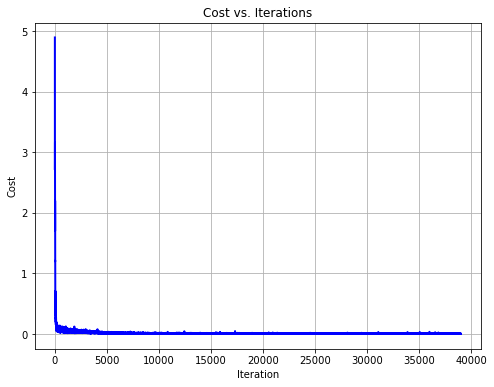

In [114]:
# ploting the cost-epoch
iterations = np.arange(0, len(costs))
with torch.no_grad():
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, costs, 'b-', linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Cost vs. Iterations")
    plt.grid(True)
    plt.show()

In [115]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Test Loss: 0.1395
